In [ ]:
import scipy
import numpy as np
import torch
import logging
import matplotlib.pyplot as plt

ftype = torch.float32
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
s_box = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]
s_box_tensor = torch.tensor(s_box, dtype=torch.int32)
hamming_weight = torch.tensor([np.bitwise_count(i) for i in range(256)], dtype=ftype)
key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6,
       0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

Dataset from:
https://github.com/ikizhvatov/randomdelays-traces/tree/master?tab=readme-ov-file

In [3]:
f = scipy.io.loadmat("randomdelays/ctraces_fm16x4_2.mat")
f.keys()

dict_keys(['__header__', '__version__', '__globals__', 'CompressedTraces', 'plaintext'])

In [4]:
plaintext = f["plaintext"]
# stored as int32 due to acting as a tensor of keys for s_box_tensor
plaintext = torch.tensor(plaintext, dtype=torch.int32)
plaintext.shape, plaintext

(torch.Size([50000, 16]),
 tensor([[201, 204,  39,  ..., 110,   7, 107],
         [165, 147, 225,  ...,  17, 250, 213],
         [ 40,  81,  70,  ..., 106, 228,   1],
         ...,
         [112,  40,  29,  ...,  54, 206, 105],
         [ 22,  16,  45,  ..., 164, 108,  63],
         [213, 237, 251,  ..., 198,  87,  66]], dtype=torch.int32))

In [5]:
traces = f["CompressedTraces"]
traces

array([[205, 189, 160, ..., 173, 177, 192],
       [189, 180, 150, ..., 199, 177, 179],
       [174, 188, 176, ..., 167, 202, 170],
       ...,
       [164, 178, 189, ..., 209, 194, 185],
       [165, 175, 183, ..., 191, 168, 186],
       [171, 175, 192, ..., 202, 168, 177]],
      shape=(3500, 50000), dtype=uint8)

The traces are compressed, containing only the peak sample for each cpu clock cycle, covering "at least the first non-dummy AES round"

In [6]:
traces = traces.T
traces = torch.tensor(traces, dtype=ftype)
traces_centered = traces - traces.mean(dim=0)
traces_std = traces.std(dim=0)

In [ ]:
def correlate_traces(plaintext: torch.tensor,
                     traces_centered: torch.tensor,
                     traces_std: torch.tensor):
    """
    Computes Pearson's R correlation between hamming weights of sbox output for
    each key hypothesis, and traces for each of 256 key hypotheses.

    Correlation is computed as Pearson's r, based on formula:
    correlation = E[(iv - mean(iv)) (trace - mean(trace))]
                  / ( std(iv) * std(trace))

    Using vectorized computation, this is performed as
    correlation = dot_product((iv - mean(iv), (trace - mean(trace))
                  / ( len(iv) * std(iv) * std(trace))

    Performance increase is gained by using precomputed traces_centered as well
    as traces_std. 

    Assumes
    - i = amount of traces
    - j = amount of samples per trace
    :plaintexts: tensor of the specific byte of plaintext, shaped (i, 1)
    :traces_centered: precomputed traces - traces.mean(axis=0), shaped (i, j)
    :traces_std: precomputed traces.std(axis=0) shaped (j,)

    :returns: array of correlations shaped (256, j)
    """
    I = plaintext.shape[0]
    iv = torch.zeros((256, I), dtype=ftype)
    for key_hypothesis in range(256):
        # Sbox(key_hypothesis ^ plaintext)
        xor = key_hypothesis ^ plaintext
        switch = torch.index_select(s_box_tensor, 0, xor)
        
        # hamming weight of sbox output
        weights = torch.index_select(hamming_weight, 0, switch)
        iv[key_hypothesis] = weights

    iv_centered = iv - iv.mean(dim=1, keepdim=True)
    iv_std = iv.std(dim=1, keepdim=True)

    # (iv - iv.mean()) * (traces - traces.mean(dim=0))
    nom = torch.matmul(iv_centered, traces_centered)
    # iv.std() * traces.std() * amount of traces I
    denom = iv_std * traces_std * I
    return nom / denom


In [8]:
corrs = torch.zeros((16, 256, traces.shape[1]), dtype=ftype)
for byte in range(16):
    key_corrs = correlate_traces(plaintext[:, byte], traces_centered, traces_std)
    corrs[byte, :, :] = key_corrs

We work with absolute values, as the direction of correlation does not matter

In [9]:
abscorr = corrs.abs()
# maximum correlation of each key hypotesis, with sample index
hypo_max_correlation, hypo_time_index = abscorr.max(dim=2)
# maximum correlation of byte, along corresponding key hypothesis
byte_max_correlation, byte_guess = hypo_max_correlation.max(dim=1)

We can see correlation for 0-th key is barely higher than for other hypotheses.

In [10]:
def check_byte(byte_index, correct_key):
    print(f"{i:2}-th byte hypothesis {byte_guess[byte_index]:3} has largest correlation {byte_max_correlation[byte_index]:.5f}", end='')
    if correct_key != byte_guess[byte_index]:
        print(f"; key is {correct_key:3} with {hypo_max_correlation[byte_index][correct_key]:.5f}")
    else:
        print(" is correct")
            

In [11]:
for i in range(16):
    check_byte(i, key[i])

 0-th byte hypothesis  43 has largest correlation 0.02478 is correct
 1-th byte hypothesis  37 has largest correlation 0.02120; key is 126 with 0.01644
 2-th byte hypothesis  47 has largest correlation 0.02387; key is  21 with 0.02134
 3-th byte hypothesis 124 has largest correlation 0.02079; key is  22 with 0.01761
 4-th byte hypothesis 211 has largest correlation 0.02283; key is  40 with 0.01794
 5-th byte hypothesis  77 has largest correlation 0.02353; key is 174 with 0.02051
 6-th byte hypothesis 196 has largest correlation 0.02037; key is 210 with 0.01648
 7-th byte hypothesis 171 has largest correlation 0.02146; key is 166 with 0.01676
 8-th byte hypothesis 184 has largest correlation 0.02077; key is 171 with 0.01802
 9-th byte hypothesis 186 has largest correlation 0.02028; key is 247 with 0.01533
10-th byte hypothesis 200 has largest correlation 0.02394; key is  21 with 0.01572
11-th byte hypothesis 109 has largest correlation 0.02433; key is 136 with 0.01651
12-th byte hypothe

It appears that correlations were low across the board. We only managed to recover 0-th key byte, however even there the correlation was low. peaking on at 0.2496 for 15-th key byte. The graph shows only noise.

In [12]:
def graph_correlation(byte_index):
    correct_key_byte = key[byte_index]
    array = corrs[byte_index]
    for i in range(256):
        if i == correct_key_byte:
            color = "green"
        else:
            color = "gray"
        plt.plot(array[i], color=color)


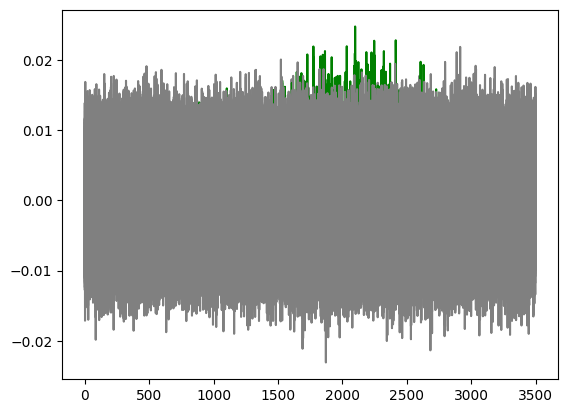

In [13]:
graph_correlation(0)

Correlation for correct key byte 0 was barely higher than other hypotheses.

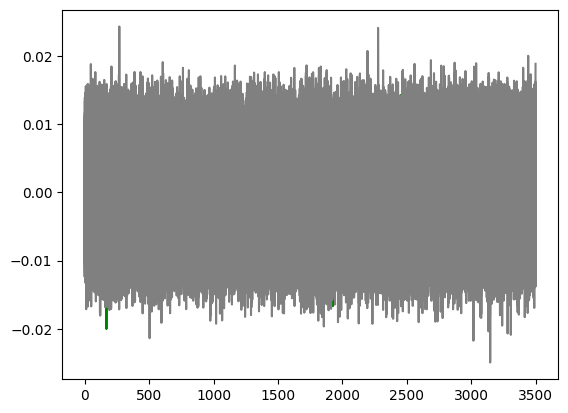

In [14]:
graph_correlation(15)